In [ ]:
!pip install face-recognition
!pip install cvlib

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from PIL import Image 
import PIL.ImageDraw
import face-recognition
import cvlib as cvl
from numpy.lib.polynomial import poly
import skimage.feature as feature
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Art movement classification 
## From machine learning to deep learning to identify the artwork

#### Eugenio Baldo, Simone Chieppa, Alessio Galimi, Francesco Pinto

# Data uploading
The data have been taken from wikiart and stored in Google Drive. The entire project has been done in Google Colab.

In [ ]:
path_tonalism='/content/drive/MyDrive/wikiart/tonalism'
path_popart='/content/drive/MyDrive/wikiart/popart'
path_pointillism='/content/drive/MyDrive/wikiart/pointillism'
path_neoexpressionism='/content/drive/MyDrive/wikiart/neoexpressionism'
path_neoclassicism='/content/drive/MyDrive/wikiart/neoclassicism'
path_naturalism='/content/drive/MyDrive/wikiart/naturalism'
path_minimalism='/content/drive/MyDrive/wikiart/minimalism'
path_high_renessaince='/content/drive/MyDrive/wikiart/high_renessaince'
path_futurism='/content/drive/MyDrive/wikiart/futurism'
path_baroque='/content/drive/MyDrive/wikiart/baroque'

Function to load the images from the folder

In [ ]:

def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = img[:,:,::-1]
            images.append(img)
    return images

In [ ]:
#Uploading all the images from the different currents
tonalism = load_images(path_tonalism)
popart = load_images(path_popart)
pointillism = load_images(path_pointillism)
neoexpressionism = load_images(path_neoexpressionism)
neoclassicism = load_images(path_neoclassicism)
naturalism = load_images(path_naturalism)
high_reneissance = load_images(path_high_renessaince)

In [ ]:
# First, we make sure we select a coloured image. The third value of the array is a 3, so we have a RGB image, not a Black and White image.
# Now we can analyze the pixel values
path='/content/drive/MyDrive/wikiart/popart/1.jpg'
img=cv2.imread(path)
img=img[:,:,::-1]
print(img.shape)


(300, 600, 3)


# First approach to the images

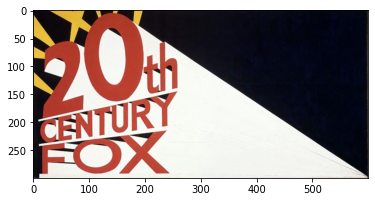

In [ ]:
# This image seems good for the analysis, since there are clearly distincted areas of different colours
plt.imshow(img)
plt.show()

In [ ]:
# We select the parts of the array relative to the each fundamental colour value
red=img[:,:,0]
green=img[:,:,1]
blue=img[:,:,2]

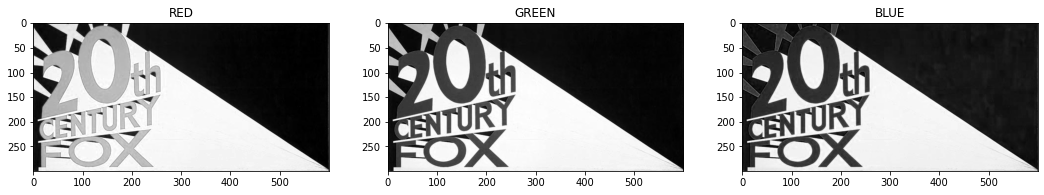

In [ ]:
plt.figure(figsize=(18,16))

plt.subplot(1,3,1)
plt.title("RED")
plt.imshow(red,cmap="gray")
plt.subplot(1,3,2)
plt.title("GREEN")
plt.imshow(green,cmap="gray")
plt.subplot(1,3,3)
plt.title("BLUE")
plt.imshow(blue,cmap="gray")
plt.show()
# Here, lighter areas correspond to higher values of the pixels, while darker areas correspond to lower values of the pixels.
# Remember that the RGB value for the colour White is (255,255,255)

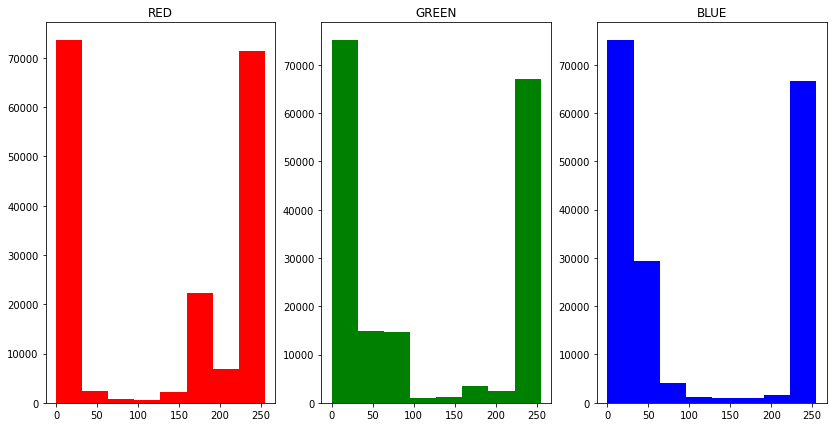

In [ ]:
plt.figure(figsize=(14,7))

plt.subplot(1,3,1)
plt.title("RED")
plt.hist(red.ravel(),bins=8,color="red")
plt.subplot(1,3,2)
plt.title("GREEN")
plt.hist(green.ravel(),bins=8,color="green")
plt.subplot(1,3,3)
plt.title("BLUE")
plt.hist(blue.ravel(),bins=8, color="blue")
plt.show()

# In the image we have 3 main colours: Black, White and Red.  Black RGB value is (0,0,0). We can see that we have a very similar number of very
# low intensity pixels for Red, Green and Blue. These pixels are the ones in the black area of the picture.
# A similar reasoning can be done for the white area (255,255,255) of the picture. But, if we look at the high intensity 
# pixels, we can see that there are more red high intensity pixels, compared to the blue and green high intensity pixels.
# This is because of the red area of the picture (255,0,0)

# Feature Extraction

Now we are gonna create different functions in order to extract the features that we will use to classify the images

### Average Hue

In [ ]:
def avg_hue(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hues = []
  rows = image.shape[0]
  cols = image.shape[1]
  for i in range(rows):
    for j in range(cols):
      hues.append(hsv[i][j][0])
  return(np.mean(hues))

### Average Saturation

In [ ]:
def avg_saturation(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  saturation = []
  rows = image.shape[0]
  cols = image.shape[1]
  for i in range(rows):
    for j in range(cols):
      saturation.append(hsv[i][j][1])
  return(np.mean(saturation))

### Color range distributions
We divide the distribution of the colors (from 1 to 255) in 20 bins and count how many colors of a certain interval are contained into an image

In [ ]:
def color_distribution(hues):
  binsd = np.linspace(0, 255, 21)
  colors = pd.DataFrame(
   {
      "col_1": [],
      "col_2": [],
      "col_3": [],
      "col_4": [],
      "col_5": [],
      "col_6": [],
      "col_7": [],
      "col_8": [],
      "col_9": [],
      "col_10": [],
      "col_11": [],
      "col_12": [],
      "col_13": [],
      "col_14": [],
      "col_15": [],
      "col_16": [],
      "col_17": [],
      "col_18": [],
      "col_19": [],
      "col_20": []
      }
   )
  for i in range(0,len(hues)):
    colors.loc[i] = list(np.histogram(hues[i], np.round(binsd))[0])
  return(colors)

### Number of faces in the image
with the face-recognition package

In [ ]:
def faces(current):
  face = []
  for i in range(len(current)):
    face_locations = face_recognition.face_locations(current[i])
    number_of_faces = len(face_locations)
    face.append(number_of_faces)
  return(face)

### Most used range of colors
we divide the colors in shades and analyze which shade is more used in an image

In [ ]:
def most_used_colors(image):
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hues = []
  rows = image.shape[0]
  cols = image.shape[1]
  for i in range(rows):
    for j in range(cols):
      hues.append(hsv[i][j][0])
  binsd = np.linspace(0, 255, 20)
  most = len(np.histogram(hues,binsd)[0][np.histogram(hues,binsd)[0] > max(np.histogram(hues, binsd)[0])*0.1])
  return(most)

### Overall Brightness

In [ ]:
def brightness(image):
  img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
  # conversion to b&w and doing the mean of the pixels (the higher is a pixel value, the whiter(brighter) is it)
  return(np.mean(img_hsv))

### Number of objects in the picture
with Canny edge detection

In [ ]:
def n_objects(current):
  objects = []

  for i in range(len(current)):
    gray= cv2.cvtColor(current[i], cv2.COLOR_BGR2GRAY)
    edges= cv2.Canny(gray, 50,200)
    contours, hierarchy= cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    objects.append(len(contours))

  return(objects)

### Variance of the Laplacian

In [ ]:
def lap_variance(image):
  # Convert to greyscale
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Find the laplacian of this image and
  # calculate the variance
  var = cv2.Laplacian(grey, cv2.CV_64F).var()
  return var

### Overall Variance of the image

In [ ]:
def variance(image):

    return((image).var())

### Average RGB values
average values of red, blue and green

In [ ]:
def rgb(current):
  red_values = []
  green_values = []
  blue_values = []

  for im in current:
    red_value = np.mean(im[:, :, 0])
    red_values.append(red_value)

    # Check the distribution of green values 
    
  for im in current:
    green_value = np.mean(im[:, :, 1])
    green_values.append(green_value)

    # Check the distribution of blue values 
    
  for im in current:
    blue_value = np.mean(im[:, :, 2])
    blue_values.append(blue_value)
  return(red_values, green_values, blue_values)

### Textural features
Contrast, dissimilarity, correlation, homogeneity, energy, ASM

In [ ]:
def get_textural_features(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = feature.greycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
    contrast = feature.greycoprops(glcm, 'contrast')[0,0]
    dissimilarity = feature.greycoprops(glcm, 'dissimilarity')[0, 0]
    correlation = feature.greycoprops(glcm, 'correlation')[0, 0]
    homogeneity = feature.greycoprops(glcm, 'homogeneity')[0, 0]
    energy = feature.greycoprops(glcm, 'energy')[0, 0]
    ASM = feature.greycoprops(glcm, 'ASM')[0,0]
    features = [contrast, dissimilarity, correlation, homogeneity, energy, ASM]
    return features

## Dataset creation

In [ ]:
def fill_df(imgs, current): #imgs is the current, current is the name of the current to classify it
  df = pd.DataFrame()
  satu = []
  hue = []
  ncol = []
  n_obj = []
  bright = []
  for img in imgs:
    hue.append(avg_hue(img))
    satu.append(avg_saturation(img))
    ncol.append(most_used_colors(img))
    bright.append(brightness(img))

  df['hue'] = hue #hue of the images
  df['saturation'] = satu #saturation of the images
  df['most_used_colors'] = ncol #number of colors used in the images
  df['brightness'] = bright #mean brightness 
  df['n_faces'] = faces(imgs) #number of realistic faces in the images
  df['num_objects'] = n_objects(imgs)#number of the objects in the images
  colors = color_distribution(imgs) #frequencies of 20 different shapes of color used in the picture
  df = pd.concat([df, colors], axis=1)

  
  df['current'] = [current]*len(ncol) #definition of the class
  return(df)

In [ ]:
tonalism_df = fill_df(tonalism, 'tonalism')
popart_df = fill_df(popart, 'popart')
pointillism_df = fill_df(pointillism, 'pointillism')
neoexpressionism_df = fill_df(neoexpressionism, 'neoexpressionism')
neoclassicism_df = fill_df(neoclassicism, 'neoclassicism')
naturalism_df = fill_df(naturalism, 'naturalism')
high_reneissance_df = fill_df(high_reneissance, 'high_reinassance')

In [ ]:
dfs = [tonalism_df, popart_df, pointillism_df, neoexpressionism_df, neoclassicism_df, naturalism_df, high_reneissance_df]
final_data = pd.concat(dfs) #final concatenation of the different dataset created for the currents

Colab had CPU problems with the dataset creation because too much features were uploaded, so the function above doesn't contain all the features, but they are added below:

In [ ]:
final_data['red_values'] = red_values
final_data['green_values'] = green_values
final_data['blue_values'] = blue_values

gg = pd.DataFrame(columns = ['contrast', 'dissimilarity', 'correlation', 'homogeneity', 'energy', 'ASM'])

for i in range(len(tonalism)):
  gg.loc[i] = (get_textural_features(tonalism[i]))
for i in range(len(popart)):
  gg.loc[i + len(tonalism)] = (get_textural_features(popart[i]))
for i in range(len(pointillism)):
  gg.loc[i + len(tonalism) + len(popart)] = (get_textural_features(pointillism[i]))
for i in range(len(neoexpressionism)):
  gg.loc[i + len(tonalism) + len(popart) + len(pointillism)] = (get_textural_features(neoexpressionism[i]))
for i in range(len(neoclassicism)):
  gg.loc[i + len(tonalism) + len(popart) + len(pointillism) + len(neoexpressionism)] = (get_textural_features(neoclassicism[i]))
for i in range(len(naturalism)):
  gg.loc[i + len(tonalism) + len(popart) + len(pointillism) + len(neoexpressionism) + len(neoclassicism)] = (get_textural_features(naturalism[i]))
for i in range(len(high_reneissance)):
  gg.loc[i + len(tonalism) + len(popart) + len(pointillism) + len(neoexpressionism) + len(neoclassicism) + len(naturalism)] = (get_textural_features(high_reneissance[i]))

In [ ]:
final_data = pd.concat([gg, final_data], axis = 1)

final_data

,contrast,dissimilarity,correlation,homogeneity,energy,ASM,hue,saturation,most_used_colors,brightness,...,col_17,col_18,col_19,col_20,current,var,lap_variance,red_values,green_values,blue_values
0,90.238706,5.279636,0.980979,0.271533,0.021024,0.000442,103.019679,108.953174,3,97.376874,...,11798.0,508.0,12.0,1.0,tonalism,2911.952961,656.953506,126.366575,103.536812,74.221347
1,135.357346,8.438557,0.947011,0.129845,0.019492,0.000380,118.687372,126.291853,3,71.799947,...,8121.0,9721.0,11162.0,9883.0,tonalism,2649.493888,853.705373,118.202036,70.066395,57.500904
2,92.114431,5.350614,0.929881,0.240275,0.030712,0.000943,101.377070,174.884019,1,136.903689,...,75127.0,106061.0,102361.0,6894.0,tonalism,4260.096665,532.654752,211.606122,157.864398,67.409790
3,91.599027,5.469926,0.991347,0.256275,0.023523,0.000553,104.116931,134.655748,2,109.798737,...,91576.0,68198.0,58576.0,49078.0,tonalism,5925.362761,561.408998,141.025974,116.136649,85.511388
4,213.559936,8.664904,0.962359,0.227688,0.019990,0.000400,109.162376,90.200941,3,101.093578,...,28658.0,330.0,28.0,1.0,tonalism,3170.122687,1360.164913,120.649423,104.510957,86.899179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5688,422.988068,11.876659,0.956178,0.149886,0.017956,0.000322,101.160655,146.992860,3,78.708347,...,31318.0,30836.0,26108.0,27107.0,high_reinassance,5352.649111,1489.628343,112.257335,80.869286,61.655879
5689,276.681490,9.097379,0.946758,0.228845,0.030706,0.000943,118.777705,129.436390,5,49.782464,...,6444.0,5592.0,4703.0,7278.0,high_reinassance,2904.531262,1058.899655,69.563445,49.960302,41.838165
5690,608.412317,15.371511,0.921087,0.126409,0.019804,0.000392,102.839735,108.866013,2,91.001675,...,23025.0,18721.0,13026.0,7553.0,high_reinassance,4265.523369,2234.687476,111.487956,96.314114,72.731539
5691,434.697828,13.340030,0.940046,0.134602,0.017258,0.000298,109.275976,146.835214,3,70.333051,...,21738.0,19305.0,15209.0,19581.0,high_reinassance,4598.924670,1658.775529,106.191993,74.235677,48.973531


In [ ]:
final_data.to_csv('dataframe_final.csv') # let's save the big dataframe

## Brief visualization of the data 
The real visualization has been done in R

In [ ]:
prova = final_data[final_data['current']=='popart'] 
prova2 = final_data[final_data['current']=='tonalism']
prova = pd.concat([prova,prova2])

fig = px.scatter_3d(prova, x='red_values', y='green_values', z='blue_values',
                    color='current',size_max=18,symbol='current')
fig.show()

## Data processing
Now the data need to be scaled! The standardization will give us better performances in terms of computation time. Every variable has been standardized, except the categorical one (most_used_colors)

In [ ]:
data_std = final_data.copy()

In [ ]:
#Standardization
std = StandardScaler()
minmax = MinMaxScaler()
data_std.loc[:, 'col_1':'col_20'] = std.fit_transform(data_std.loc[:, 'col_1':'col_20'])
data_std.loc[:, 'hue':'saturation'] = std.fit_transform(data_std.loc[:, 'hue':'saturation'])
data_std.loc[:, 'num_objects'] = std.fit_transform(np.asarray(data_std.loc[:, 'num_objects']).reshape(-1,1))
data_std.loc[:,'n_faces'] = std.fit_transform(np.asarray(data_std.loc[:,'n_faces']).reshape(-1,1))
data_std.loc[:,'brightness'] = std.fit_transform(np.asarray(data_std.loc[:,'brightness']).reshape(-1,1))
data_std.loc[:,'red_values'] = std.fit_transform(np.asarray(data_std.loc[:,'red_values']).reshape(-1,1))
data_std.loc[:,'green_values'] = std.fit_transform(np.asarray(data_std.loc[:,'green_values']).reshape(-1,1))
data_std.loc[:,'blue_values'] = std.fit_transform(np.asarray(data_std.loc[:,'blue_values']).reshape(-1,1))
data_std.loc[:, 'contrast':'ASM'] = std.fit_transform(data_std.loc[:, 'contrast':'ASM'])
data_std.loc[:,'var'] = std.fit_transform(np.asarray(data_std.loc[:,'var']).reshape(-1,1))
data_std.loc[:,'lap_variance'] = std.fit_transform(np.asarray(data_std.loc[:,'lap_variance']).reshape(-1,1))
data_std

# Estimates
first of all let's distinguish the design matrix X and the labels y

In [ ]:
train_X = data_std.loc[:, data_std.columns != 'current']
train_Y = data_std.loc[:,'current']

now let's implement the K-fold cross validation

In [ ]:
kfold=KFold(n_splits=10,shuffle=True,random_state=123)

### The failed models

Before findinf the best model below, we tried four other different models that performed bad:


* Support Vector Classifier
* K-Nearest Neighbour
* XGBoost Classifier
* AdaBoost Classifier

But then we found him... the...


### HistGradientBoosting Classifier
By using a gridsearch (GridSearchCV from sklearn.modelselection) we tuned over 4000 combinations of parameters, discovering that the best parameters for our problem are


*   Learning Rate: 0.15
*   Minimum sample leaf: 10
* Maximum iterations: 310
* Loss function: Categorical entropy
* (seed = 123)



In [ ]:
hgb=HistGradientBoostingClassifier(random_state=123, learning_rate=0.15, min_samples_leaf=10, max_iter=310, 
                                   loss = 'categorical_crossentropy')
scores=cross_val_score(hgb,train_X,train_Y,scoring="accuracy",cv=kfold)
print(np.mean(scores))

0.695


due to the fact that cross_val_score have problems in finding f1-score, precision and recall, we find them in another way

In [ ]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size = 0.2, random_state = 123)
#Fitting
hgb.fit(X_train, y_train)
#Predicting
preds = hgb.predict(X_test)

print('the precision score on the test set is',precision_score(y_test,preds,average='macro'))
print('the recall score on the test set is',recall_score(y_test,preds,average='macro'))
print('the f1 score on the test set is',f1_score(y_test,preds,average='macro'))

the precision score on the test set is 0.6704329559720484 
 the recall score on the test set is 0.6496253427633024 
 the f1 score on the test set is 0.6560961777380468


And now the confusion matrix

In [ ]:
conf_matrix=confusion_matrix(y_test,preds,normalize='true')

plt.figure(figsize=(16,9))

sns.heatmap(conf_matrix,annot=True,xticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                           ], yticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                          ])

#plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()

# Image classification with CNN 

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras import losses, optimizers, metrics, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:
#resize the image for each art movement to have all the same shapes

In [ ]:
def resize_image(image):
        
      image=tf.image.resize(image,size=[160,160],method='gaussian',preserve_aspect_ratio=False,antialias=False) #resize in a feasible number of pixels
      image=tf.cast(image, tf.float32) / 255.0 #normalizing pixels values in range(0,1)
      image=image.numpy()
      return image

In [ ]:
popart[0].shape

(600, 439, 3)

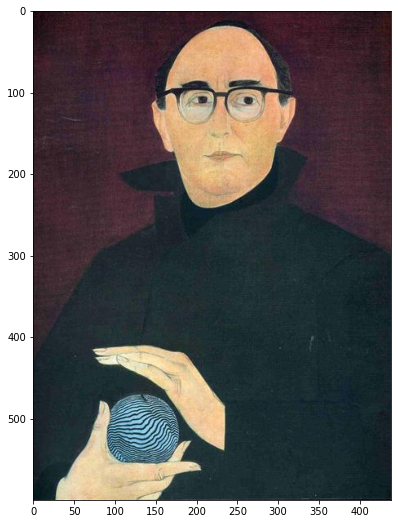

In [ ]:
#original image
plt.figure(figsize=(16,9))
plt.imshow(popart[0])
plt.show()

In [ ]:
tonalism = list(map(lambda x:resize_image(x),tonalism)) #label 0
popart = list(map(lambda x:resize_image(x),popart)) # label 1
pointillism = list(map(lambda x:resize_image(x),pointillism)) #label 2
neoexpressionism = list(map(lambda x:resize_image(x),neoexpressionism)) #label 3
neoclassicism = list(map(lambda x:resize_image(x),neoclassicism)) #label 4
naturalism = list(map(lambda x:resize_image(x),naturalism)) #label 5
high_reneissance = list(map(lambda x:resize_image(x),high_reneissance)) #label 6
#minimalism = list(map(lambda x:resize_image(x),minimalism))#label 7
#futurism = list(map(lambda x:resize_image(x),futurism)) #label 8
#baroque = list(map(lambda x:resize_image(x),baroque)) #label 9

In [ ]:
popart[0].shape

(160, 160, 3)

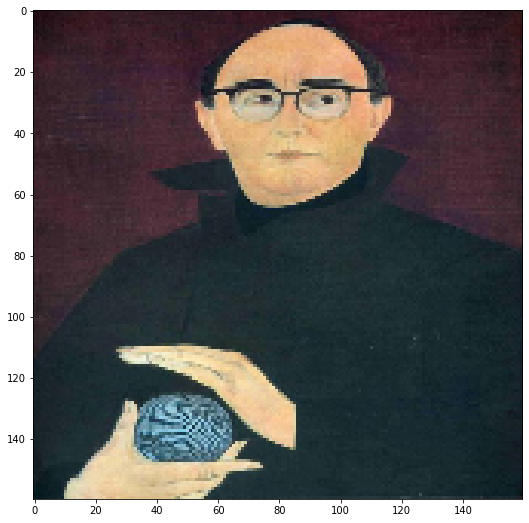

In [ ]:
#resized image
plt.figure(figsize=(16,9))
plt.imshow(popart[0])
plt.show()

In [ ]:
X=np.array([*tonalism,*popart,*pointillism,*neoexpressionism,*neoclassicism,*naturalism,*high_reneissance]) #concatenate the images from different classes
y=np.array([*[0 for i in range(len(tonalism))],*[1 for i in range(len(popart))],*[2 for i in range(len(pointillism))],*[3 for i in range(len(neoexpressionism))],*[4 for i in range(len(neoclassicism))],*[5 for i in range(len(naturalism))],
*[6 for i in range(len(high_reneissance))]])


In [ ]:
print('X length:',len(X))
print('y length:',len(y))

X length: 5693
y length: 5693


In [ ]:
#save memoty
del tonalism
del popart
del pointillism
del neoexpressionism
del neoclassicism
del naturalism
del high_reneissance

In [ ]:
#the following function applied to the training provides data augmentation by augmenting and reducing saturation
def train_augment(x,y):

  x=tf.image.adjust_saturation(x,0.5)
  x=tf.image.adjust_saturation(x,1.5)
  
  return x,y

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_temp,y_temp,test_size=0.5)

In [ ]:
del X

In [ ]:
del y

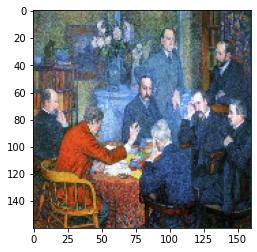

In [ ]:
plt.imshow(X_train[500])

In [ ]:
y_train[500]

2

In [ ]:
def build_model():
    inputs = Input((160, 160, 3))
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    x = GlobalAveragePooling2D()(x)

    out = Dense(7)(x)


    model = Model(inputs, out)
    return model

In [ ]:
model=build_model()

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 160, 160, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 80, 80, 128)      0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 80, 80, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                      

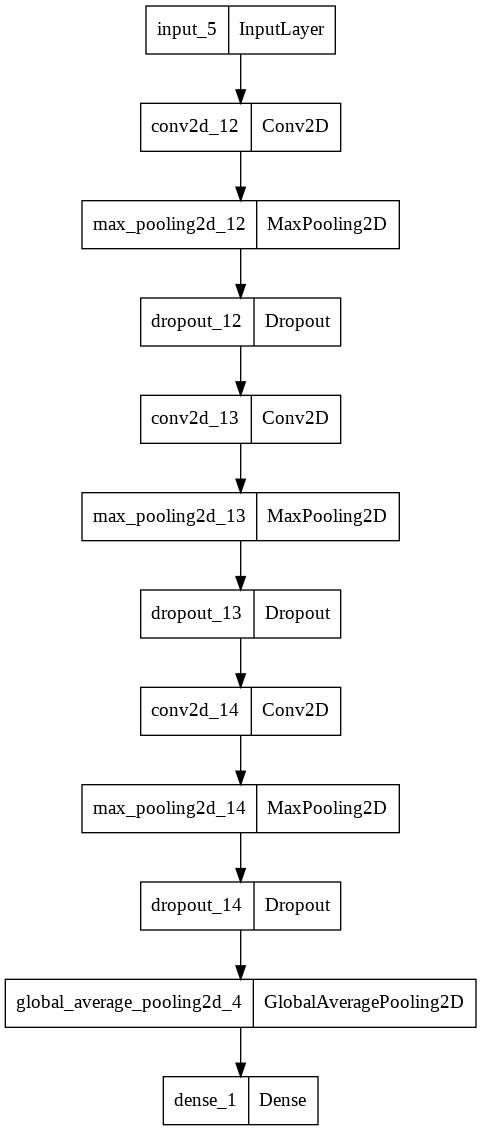

In [ ]:
plot_model(model,'model.png')

In [ ]:
data_train=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(64).map(train_augment).prefetch(tf.data.AUTOTUNE)
data_val=tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(64)

In [ ]:
!pip install --q wandb
import wandb
from wandb.keras import WandbCallback

!wandb login 

wandb.init(project="art_classification")


     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 153 kB 67.2 MB/s 
     |████████████████████████████████| 181 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: eugibaldo. Use `wandb login --relogin` to force relogin


In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=optimizers.SGD(0.001,momentum=0.9),metrics=[metrics.SparseCategoricalAccuracy()])

In [ ]:
model.fit(data_train,epochs=300,callbacks=[callback,WandbCallback()],validation_data=data_val)

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,██▇▇▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▁▂▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███████████
val_loss,██▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▂▃▂▂▃▂▃▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁
val_sparse_categorical_accuracy,▁▂▃▃▄▄▅▅▅▅▆▆▆▅▇▆▆▇▆▇▇▇▇▆▇▇▇▇▇▇█▇████████
GFLOPS,1.27245
best_epoch,291
best_val_loss,0.92652
epoch,299
loss,0.92833
sparse_categorical_accuracy,0.64778


In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/my_model.h5')

**evaluation on test set**

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score,f1_score
import seaborn as sns

In [ ]:
y_preds_test=model.predict(X_test)
y_preds_test=tf.math.argmax(y_preds_test,axis=1).numpy()

In [ ]:
print(len(y_preds_test))

569


In [ ]:
y_preds_test[0:10]

array([5, 4, 0, 5, 2, 3, 6, 4, 5, 2])

In [ ]:
print(len(y_test))

569


In [ ]:
y_test[0:10]

array([5, 5, 3, 6, 2, 3, 6, 4, 5, 2])

the accuracy score on the test set is 0.6291739894551845
the precision score on the test set is 0.6399090520782271
the recall score on the test set is 0.629651349796185
the f1-score score on the test set is 0.6199345757200329


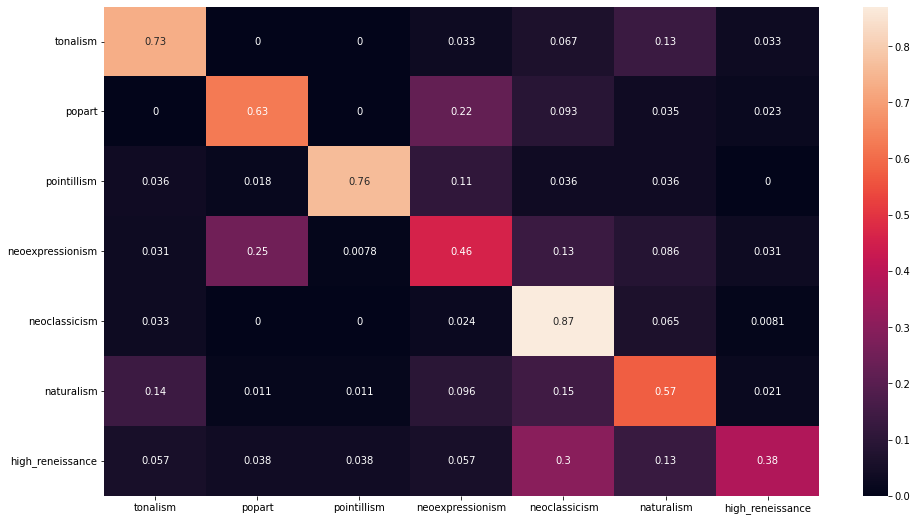

In [ ]:
print('the accuracy score on the test set is',accuracy_score(y_test,y_preds_test))
print('the precision score on the test set is',precision_score(y_test,y_preds_test,average='macro'))
print('the recall score on the test set is',recall_score(y_test,y_preds_test,average='macro'))
print('the f1-score score on the test set is',f1_score(y_test,y_preds_test,average='macro'))

conf_matrix=confusion_matrix(y_test,y_preds_test,normalize='true')

plt.figure(figsize=(16,9))

sns.heatmap(conf_matrix,annot=True,xticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                           ], yticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                           ])

plt.savefig('/content/drive/MyDrive/confusion_matrix_cnn.png')

plt.show()

## Model Interpretation ##

In [ ]:
model.layers

In [ ]:
first_conv=model.layers[1]

In [ ]:
weights=first_conv.get_weights()
kernels=weights[0]
kernels.shape
# 3x3 kernel size, RGB, 128 kernels in this layer

(3, 3, 3, 128)

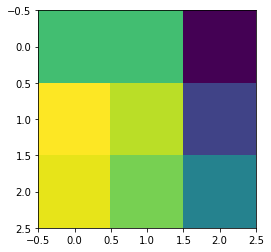

In [ ]:
first_kernel_red=kernels[:,:,0,19]
plt.imshow(first_kernel_red) 
# this kernel seems to focus on horizontal lines

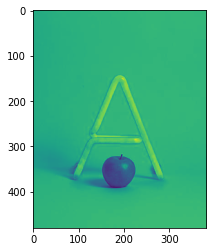

In [ ]:
path="/content/drive/MyDrive/wikiart/popart/a-for-apple-1963.jpg"
img=cv2.imread(path)
img=img[:,:,::-1]

image_red=img[:,:,0]
plt.imshow(image_red)

In [ ]:
def convolution(im, kernel):
  result = np.zeros(im.shape)
  k=kernel.shape[0]
  # Output array
  for ii in range(im.shape[0] - k):
    for jj in range(im.shape[1] - k):
        result[ii, jj] = (im[ii:ii+k, jj:jj+k] * kernel).sum()
  return(result)

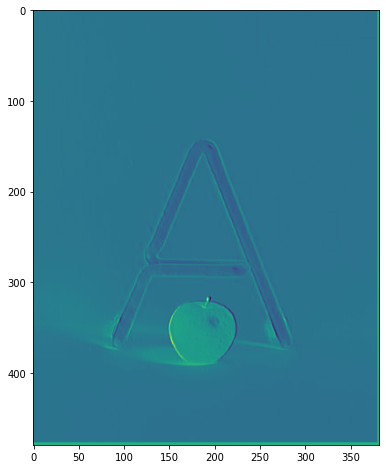

In [ ]:
filtered_img=convolution(image_red,first_kernel_red)
plt.figure(figsize = (8,8))
plt.imshow(filtered_img)
# The best horizontal edge (the bottom of the apple) is clearly detected

### using CNN to embed features, and SVM to classify the embeddings of the images ###

In [ ]:
def build_extractor_model():
    
    inputs = Input((160, 160, 3))
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.2)(x)

    out = GlobalAveragePooling2D()(x)

    model = Model(inputs, out)

  
    return model

In [ ]:
feature_extractor_model=build_extractor_model() #initialize the extractor model

for i in range(len(model.weights)-2): #assign weights to the previously trained model until the softmax layer W,b (len(model.weights)-2)
    
    feature_extractor_model.weights[i].assign(model.weights[i])

In [ ]:
feature_extractor_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 128)     3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 80, 80, 128)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 80, 80, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                      

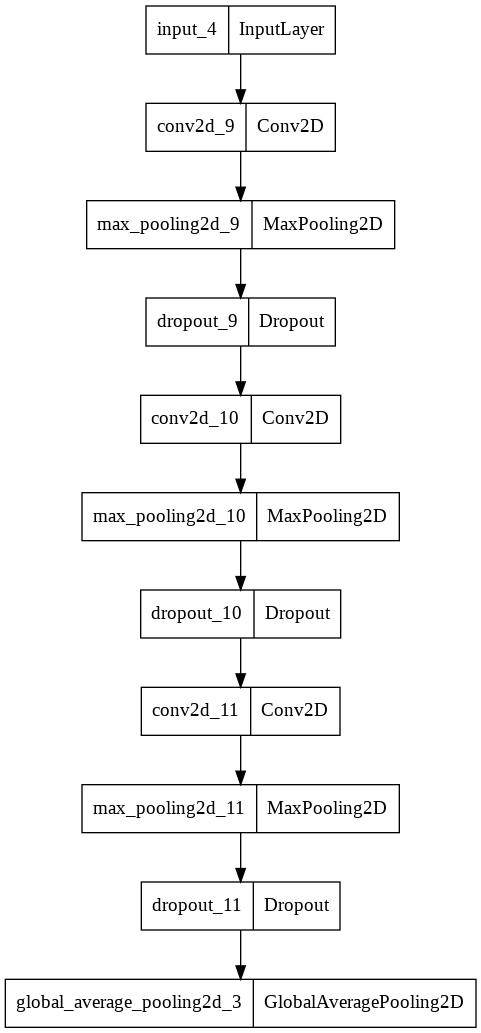

In [ ]:
plot_model(feature_extractor_model,'model_cnn_svm.png')

**trasform Images in encoding**

In [ ]:
from tqdm import tqdm

In [ ]:
X_emb_train=feature_extractor_model.predict(X_train)

In [ ]:
X_emb_train.shape

(4554, 128)

In [ ]:
y_train.shape

(4554,)

In [ ]:
X_emb_test=feature_extractor_model.predict(X_test)

In [ ]:
X_emb_test.shape

(569, 128)

In [ ]:
y_test.shape

(569,)

**SVM MODEL**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
import seaborn as sns

In [ ]:
grid={'C':[1,10,50,100],'gamma':['scale','auto'],'kernel':['poly','rbf']}



search=GridSearchCV(estimator=SVC(verbose=True),param_grid=grid,scoring='accuracy',n_jobs=-1,cv=3)

search.fit(X_emb_train,y_train)

print(search.best_params_)

print(search.best_score_)


[LibSVM]{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.702239789196311


In [ ]:
clf=SVC(C=100,gamma='auto',kernel='rbf')

clf.fit(X_emb_train,y_train)

preds=clf.predict(X_emb_test)


the accuracy score on the test set is 0.7012302284710018
the precision score on the test set is 0.7047929009203822
the recall score on the test set is 0.6972010557298428
the f1 score on the test set is 0.6991607547401072


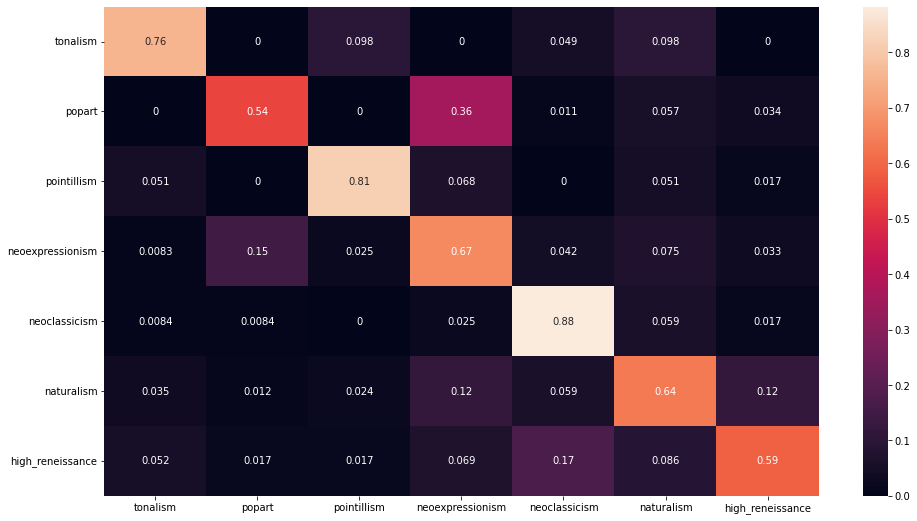

In [ ]:
print('the accuracy score on the test set is',accuracy_score(y_test,preds))
print('the precision score on the test set is',precision_score(y_test,preds,average='macro'))
print('the recall score on the test set is',recall_score(y_test,preds,average='macro'))
print('the f1 score on the test set is',f1_score(y_test,preds,average='macro'))

conf_matrix=confusion_matrix(y_test,preds,normalize='true')

plt.figure(figsize=(16,9))

sns.heatmap(conf_matrix,annot=True,xticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                           ], yticklabels=["tonalism","popart","pointillism","neoexpressionism",
                                           "neoclassicism","naturalism","high_reneissance",
                                          ])

plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()